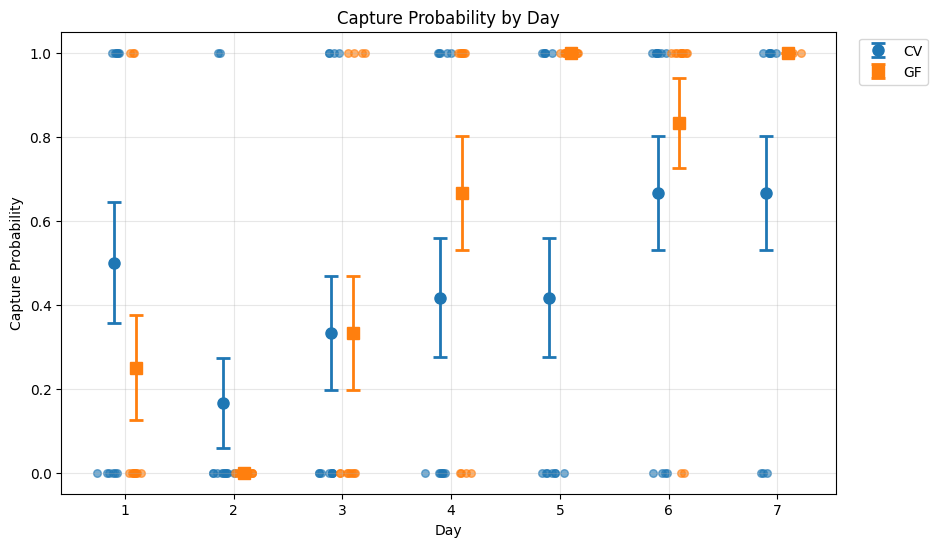

Group Statistics (Mean ± SEM):
Day 1:
  Group A: 0.25 ± 0.131
  Group C: 0.5 ± 0.151
Day 2:
  Group A: 0.0 ± 0.0
  Group C: 0.167 ± 0.112
Day 3:
  Group A: 0.333 ± 0.142
  Group C: 0.333 ± 0.142
Day 4:
  Group A: 0.667 ± 0.142
  Group C: 0.417 ± 0.149
Day 5:
  Group A: 1.0 ± 0.0
  Group C: 0.417 ± 0.149
Day 6:
  Group A: 0.833 ± 0.112
  Group C: 0.667 ± 0.142
Day 7:
  Group A: 1.0 ± 0.0
  Group C: 0.667 ± 0.167


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Set matplotlib to use default style (not seaborn)
plt.style.use('default')

# Read and process the data
def load_data(filename):
    df = pd.read_csv(filename)
    
    # Extract group and trial from Sample_ID (e.g., A1_F2 -> Group=A, Gender=F, Trial=2)
    df['Group'] = df['Sample_ID'].str[0]  # First character
    df['Gender'] = df['Sample_ID'].str.split('_').str[1].str[0]  # F or M
    df['Trial'] = df['Sample_ID'].str.split('_').str[1].str[1:].astype(int)  # Trailing number
    
    return df

def extract_approach_data(df, group):
    """Extract approach data in the format expected by plot_metric_across_days"""
    group_data = df[df['Group'] == group]
    approach_data = {}
    
    for day in group_data['Day'].unique():
        day_data = group_data[group_data['Day'] == day]
        approach_data[str(day)] = {
            'Captures': day_data['Captures'].tolist()
        }
    
    return approach_data

def plot_metric_across_days(approach_data_group1, approach_data_group2=None, metric_key=None, title=None, ylabel=None, ax=None, group1_name='Group 1', group2_name='Group 2', plot_type='scatter'):
    """
    Plot a specific metric across days with scatter plots for individual values
    
    Parameters:
    approach_data_group1: dict - output from extract_approach_data function for first group
    approach_data_group2: dict - output from extract_approach_data function for second group (optional)
    metric_key: str - key for the metric to plot (e.g., 'num_approach_events')
    title: str - plot title (optional)
    ylabel: str - y-axis label (optional)
    ax: matplotlib axis - axis to plot on (optional, creates new figure if None)
    group1_name: str - name for first group in legend (default: 'Group 1')
    group2_name: str - name for second group in legend (default: 'Group 2')
    plot_type: str - 'scatter' (default: 'scatter')
    """
    # Use matplotlib default colors
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    if ax is None:
        plt.figure(figsize=(10, 6))
        ax = plt.gca()
    
    # Get days
    days = sorted([int(day) for day in approach_data_group1.keys() if day.isdigit()])
    
    # Add scatter plots and means
    means1 = []
    sems1 = []
    
    for day in days:
        day_str = str(day)
        if day_str in approach_data_group1 and metric_key in approach_data_group1[day_str]:
            values = approach_data_group1[day_str][metric_key]
            means1.append(np.nanmean(values))
            sems1.append(np.nanstd(values) / np.sqrt(len(values)))
            
            # Add scatter plot for individual values with minimal jitter
            jitter = np.random.normal(0, 0.05, len(values))  # Small random jitter
            day_values = [day - 0.1] * len(values) + jitter
            ax.scatter(day_values, values, alpha=0.6, s=30, color=colors[0])
        else:
            means1.append(np.nan)
            sems1.append(np.nan)
    
    # Plot mean with error bars for group 1 (no line connecting points)
    ax.errorbar([d - 0.1 for d in days], means1, yerr=sems1, marker='o', capsize=5, capthick=2, color=colors[0], 
                markersize=8, linewidth=2, linestyle='none', label=f'{group1_name}')
    
    # Plot second group if provided
    if approach_data_group2 is not None:
        days2 = sorted([int(day) for day in approach_data_group2.keys() if day.isdigit()])
        means2 = []
        sems2 = []
        
        for day in days2:
            day_str = str(day)
            if day_str in approach_data_group2 and metric_key in approach_data_group2[day_str]:
                values = approach_data_group2[day_str][metric_key]
                means2.append(np.nanmean(values))
                sems2.append(np.nanstd(values) / np.sqrt(len(values)))
                
                # Add scatter plot for individual values with slight offset and minimal jitter
                jitter = np.random.normal(0, 0.05, len(values))  # Small random jitter
                day_values = [day + 0.1] * len(values) + jitter  # Small offset to avoid overlap
                ax.scatter(day_values, values, alpha=0.6, s=30, color=colors[1])
            else:
                means2.append(np.nan)
                sems2.append(np.nan)
        
        # Plot mean with error bars for group 2 (no line connecting points)
        ax.errorbar([d + 0.1 for d in days2], means2, yerr=sems2, marker='s', capsize=5, capthick=2, 
                    color=colors[1], markersize=8, linewidth=2, linestyle='none', label=f'{group2_name}')
    
    ax.set_xlabel('Day')
    if ylabel:
        ax.set_ylabel(ylabel)
    else:
        ax.set_ylabel(metric_key.replace('_', ' ').title())
    
    if title:
        ax.set_title(title)
    else:
        ax.set_title(f'{metric_key.replace("_", " ").title()} Across Days')
    
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
    
    if ax == plt.gca():
        plt.show()

def plot_simple_averages(filename):
    df = load_data(filename)
    
    # Filter for groups A and C
    df = df[df['Group'].isin(['A', 'C'])]
    
    # Extract approach data for both groups
    approach_data_A = extract_approach_data(df, 'A')
    approach_data_C = extract_approach_data(df, 'C')
    
    # Use the plot_metric_across_days function
    plot_metric_across_days(
        approach_data_group1=approach_data_C,
        approach_data_group2=approach_data_A,
        metric_key='Captures',
        title='Capture Probability by Day',
        ylabel='Capture Probability',
        group1_name='CV',
        group2_name='GF',
        plot_type='scatter'
    )
    
    # Print the statistics
    print("Group Statistics (Mean ± SEM):")
    group_stats = df.groupby(['Group', 'Day'])['Captures'].agg(['mean', 'sem']).reset_index()
    pivot_mean = group_stats.pivot(index='Day', columns='Group', values='mean').round(3)
    pivot_sem = group_stats.pivot(index='Day', columns='Group', values='sem').round(3)
    
    for day in pivot_mean.index:
        print(f"Day {day}:")
        for group in pivot_mean.columns:
            print(f"  Group {group}: {pivot_mean.loc[day, group]} ± {pivot_sem.loc[day, group]}")

# Run the analysis
if __name__ == "__main__":
    plot_simple_averages('/home/arnab/Downloads/BehavorialVideoGraphs(Captures).csv')